# O-GlcNAc Prediction

* Find this notebook at `EpyNN/nnlive/ptm_protein/train.ipynb`.
* Regular python code at `EpyNN/nnlive/ptm_protein/train.py`.

In this notebook we will review:

* Handling sequential string data which represents peptides sequences.
* Training of Feed-Forward (FF) and recurrent networks (LSTM).
* LSTM-based schemes with ``sequences=True``, multiple dense layers and dropout.

Please see the following if you get lost:

* [Fully Connected (Dense)](../../Dense.html)
* [Long Short-Term Memory (LSTM)](../../LSTM.html)
* [Dropout - Regularization](../../Dropout.html)

## Environment and data

Follow [this link](prepare_dataset.ipynb) for details about data preparation.

Briefly, one set of sample features contains 21 amino-acids long peptides.

Positive peptides are *Homo sapiens* peptides retrieved from [The O-GlcNAc Database](https://www.oglcnac.mcw.edu). These peptides were all experimentally demonstrated to undergo *O*-GlcNAcylation which is an ubiquitary protein Post-Translational Modification (PTM).

Negative peptides are *presumably not* modified peptides. These sequences are part of a running project so we will not say much about them excepted that they are not present in the *O*-GlcNAc Database.

Disclaimer: We are the authors of both EpyNN and the *O*-GlcNAc Database \[[1](https://www.nature.com/articles/s41597-021-00810-4), [2](https://academic.oup.com/database/article/doi/10.1093/database/baab039/6323965)\].

In [1]:
# EpyNN/nnlive/ptm_protein/train.ipynb
# Standard library imports
import random

# Related third party imports
import numpy as np

# Local application/library specific imports
import nnlibs.initialize
from nnlibs.commons.library import (
    configure_directory,
    read_model,
)
from nnlibs.commons.maths import relu, softmax
from nnlibs.network.models import EpyNN
from nnlibs.embedding.models import Embedding
from nnlibs.lstm.models import LSTM
from nnlibs.flatten.models import Flatten
from nnlibs.dropout.models import Dropout
from nnlibs.dense.models import Dense
from prepare_dataset import (
    prepare_dataset,
    download_sequences,
)
from settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')
np.seterr(under='ignore')

configure_directory()

############################ DATASET ##########################
download_sequences()

X_features, Y_label = prepare_dataset(N_SAMPLES=1280)

Let's inspect our data.

In [2]:
print(len(X_features))     # Number of sequences (samples)
print(len(X_features[0]))  # Length of sequence (features)
print(X_features[0])       # First sequence
print(Y_label[0])          # Associated label

1280
21
['T', 'A', 'A', 'M', 'R', 'N', 'T', 'K', 'R', 'G', 'S', 'W', 'Y', 'I', 'E', 'A', 'L', 'A', 'Q', 'V', 'F']
0


Note that this sequence has zero-label, meaning that it is presumably not modified.

However.

In [3]:
print(X_features[0][:10], X_features[0][10], X_features[0][11:])

['T', 'A', 'A', 'M', 'R', 'N', 'T', 'K', 'R', 'G'] S ['W', 'Y', 'I', 'E', 'A', 'L', 'A', 'Q', 'V', 'F']


Note the 11th amino-acids is a serine (S), although this sequence is presumably not modified.

Time to recall that *O*-GlcNAcylation does impact a subset of serine and threonine within the whole set of such amino-acids in proteins.

All sequences in this exemple were centered: 10 amino-acids on the left side; the S or T amino-acid; ten other amino-acids on the right side.

Negative sequences all contain a S or a T at the 11th position, as the positive sequences do. This to avoid biasing the problem: it is of interest to know which sequence containing S or T may be modified. But it has no interest to train a network at finding out that sequences with no S or T will not be modified. That's trivial.

About N- and C- terminal moities of proteins which are prone to PTMs: on those we can not follow the format \[10 amino-acids\] \[S or T\] \[10 amino-acids\] just because if S/T is at position 6, there is only 5 amino-acids on the left side.

Below is a list of options in this case:

* **Exclude those peptides**: Well, this is the *technically* best option but in terms of biological relevance that is the worse: because protein extremities are most often unstructured and/or solvent-exposed, they are over-represented to undergo modifications. So we must include them otherwise our dataset will not be representative of the problem.
* **Go with \[5 amino-acids\] \[S or T\] \[10 amino-acids\]**: While this can be done using recurrent architectures which accepts input sequences of variable length, it can not be done with pure Feed-Forward networks. Recurrent architectures process the sequence steps one by one and the weights are defined with respect to the number of recurrent cells and vocabulary size, not the length of the sequence. But Feed-Forward network and precisely the *dense* layer has one dimension less compared to the *RNN* layer. Weight shape is defined with respect to the number of nodes and features. Therefore, if the latter changes, the maths can not operate as it is.
* **Pad the sequence such as \[0, 0, 0, 0, 0\] \[5 amino-acids\] \[S or T\] \[10 amino-acids\]**: This enables to include such peptides in our dataset regardless if we intend to use Feed-Forward or recurrent architectures. Moreover, it preserves the centering around the 11th position and explicitely states that *"the number of padding characters is proportional to the closeness of the S/T from the protein first (left side) or last (right side) amino-acid"*

We have choosen the last option, padding, and used the character ``_`` instead of zero to avoid confusion between data types.

In [4]:
print('\n'.join([''.join(features) for features in X_features if '_' in features][0:10]))

GTEGKSRGSSSSSRCL_____
SASGAASTTTTASKAQ_____
CSIPSIKPPSTAN________
VGNFTGAKQASSQSWVPG___
PNQSFPHSVKTTTHSWVSG__
_______MIATPLKHSRIYLP
________MKTPNAQEAEGQQ
________MPSDLAKKKAAKK
______MDPNTIIEALRGTMD
___MAAAAELSLLEKSLGLSK


Therefore, the character ``_`` is part of our vocabulary size along with the 20 canonical amino-acids.

## Feed-Forward (FF)

We will give it a quick try with a 2-layers Feed-Foward network regularized by a double dropout. We already had much discussions about this architecture in other notebook so we pass. 

Just note that the following network consider each data point as independant from others around. Said differently, it considers *a priori* that the probability of a given residue type at position ``i`` is unrelated to the residue type at position ``i - 1``. Which we know is not true. Amino-acids have each their own distribution, but the arrangement of amino-acids between each others in proteins is not random, there are more frequent combinations with respect to amino-acids distributions.

### Embedding

We proceed with one-hot encoding of sample string features and label.

In [5]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

We have set a batch size of 32, this setting is empirical. You may want to change it and see.

### Flatten-(Dense)n with Dropout

Since we already discussed this architecture (e.g. ), we proceed readily.

In [6]:
name = 'Flatten_Dropout-02_Dense-64-relu_Dropout-03_Dense-2-softmax'

se_hPars['learning_rate'] = 0.001

flatten = Flatten()

dropout1 = Dropout(drop_prob=0.2)

hidden_dense = Dense(64, relu)

dropout2 = Dropout(drop_prob=0.3)

dense = Dense(2, softmax)

layers = [embedding, flatten, dropout1, hidden_dense, dropout2, dense]

model = EpyNN(layers=layers, name=name)

We can go ahead and initialize the model.

In [7]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Start the training.

In [8]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 25/25 - Accuracy: 0.875 Cost: 0.10997 - TIME: 17.31s RATE: 8.48e+04e/s TTC: 0s

+-------+----------+----------+-------+----------+-------+-------+------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                               Experiment                               |
|       |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                        |
+-------+----------+----------+-------+----------+-------+-------+------------------------------------------------------------------------+
|   0   | 1.00e-03 | 1.00e-03 | 0.504 |  0.424   | 0.259 | 0.273 | 1630337613_Flatten_Dropout-02_Dense-64-relu_Dropout-03_Dense-2-softmax |
|  10   | 1.00e-03 | 1.00e-03 | 0.580 |  0.571   | 0.239 | 0.242 | 1630337613_Flatten_Dropout-02_Dense-64-relu_Dropout-03_Dense-2-softmax |
|  20   | 1.00e-03 | 1.00e-03 | 0.649 |  0.597   | 0.221 | 0.23

We are pretty much overfitting the training data whereas we used a double dropout. 

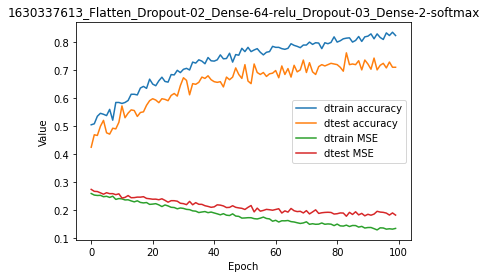

In [9]:
model.plot(path=False)

We could try to optimize by using a different loss function, adding one hidden *dense* layer or decreasing the number of nodes while increasing the learning rate etc... But we will not herein, because we want to work with recurrent architectures :).

## Recurrent Architectures

Let see the big picture.

Sequence logo of **Homo sapiens** *O*-GlcNAcylated peptides consensus from [The O-GlcNAc Database Consensus](https://www.oglcnac.mcw.edu/consensus/) page.

![Sequence logo Homo-sapens O-GlcNAcylated peptides](dl_seqlogo_ST_Homo.png)

This is what is classically looked at when quickly evaluating if a sequence may or may not be modified: herein residues with positive values on the y-axis are over-represented within modified peptides while those with negative y-axis values are under-represented. This with respect to the position on the x-axis.

While this plot provides information on amino-acid distribution with respect to a given position, it provides zero information about amino-acid distribution with respect to position in the context of the sequence.

Just making a simple drawing:

In [10]:
seqA = 'AAA'
seqB = 'BBB'

The consensus for those two sequences is 50/50 A/B with respect to position in sequence.

In [11]:
seqA = 'BAB'
seqB = 'ABA'

The consensus for those two sequences is 50/50 A/B with respect to position in sequence.

Said differently: the consensus is the same, while the character patterns are totally unrelated.

Conclusion: when representing sequences with metrics that exclude the sequential nature of the data, we may get quite misleading representations overall.

That's where the recurrent architectures comes in: it postulates *a priori* that elements in one sequence are linked together. When processing samples features step by step - or position by position -, the output at a given position integrates results gained from the past positions. This intrinsically - hard-written - in the code of the architecture.

### Embedding

Here we use the same embedding settings than for the Feed-Forward network.

In [12]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

We may continue with either using *RNN* or *GRU* or *LSTM* layers. We go ahead with LSTM first.

### LSTM-Dense

Briefly, the advtange of using LSTM cells in one LSTM layer is that it *"retains"* the information for more sequence steps compared to the simple *RNN*. The drawback is that it takes significantly longer computational time compared to the simple *RNN*.

In [13]:
name = 'LSTM-8_Dense-2-softmax'

se_hPars['learning_rate'] = 0.1
se_hPars['softmax_temperature'] = 5

lstm = LSTM(8)

dense = Dense(2, softmax)

layers = [embedding, lstm, dense]

model = EpyNN(layers=layers, name=name)

Here we have set a *LSTM* layer with 8 units and all defaults.

The output of the LSTM layer will be fed in the *dense* output layer.

In [14]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train the model.

In [15]:
model.train(epochs=20, init_logs=False)

Epoch 19 - Batch 25/25 - Accuracy: 0.875 Cost: 0.11357 - TIME: 8.06s RATE: 2.14e+03e/s TTC: 0s

+-------+----------+----------+-------+----------+-------+-------+-----------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |            Experiment             |
|       |   LSTM   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                   |
+-------+----------+----------+-------+----------+-------+-------+-----------------------------------+
|   0   | 1.00e-01 | 1.00e-01 | 0.509 |  0.499   | 0.246 | 0.249 | 1630337632_LSTM-8_Dense-2-softmax |
|   2   | 1.00e-01 | 1.00e-01 | 0.737 |  0.717   | 0.206 | 0.211 | 1630337632_LSTM-8_Dense-2-softmax |
|   4   | 1.00e-01 | 1.00e-01 | 0.748 |  0.740   | 0.187 | 0.194 | 1630337632_LSTM-8_Dense-2-softmax |
|   6   | 1.00e-01 | 1.00e-01 | 0.805 |  0.773   | 0.143 | 0.152 | 1630337632_LSTM-8_Dense-2-softmax |
|   8   | 1.00e-01 | 1.00e-01 | 0.842 |  0.829   | 0.122 | 0.130 | 1630337632_LS

Plot results.

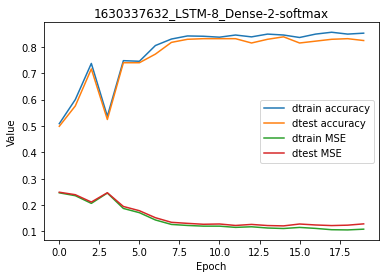

In [16]:
model.plot(path=False)

Results here are pretty good, with ~84% accuracy for both training and testing sets (epoch 14). Let's try to add more complexity in the model.

### LSTM(sequence=True)-Flatten-Dense

By defaults, the LSTM layer returns the hidden state computed at the last sequence step.

Consistently, gradients - what is actually used to update parameters - are computed with respect to this single last hidden step.

While this last hidden state incorporates information with respect to the whole sequence, it is commonly found that returning all hidden states and computing gradients with respect to each of them provides better results than the default behavior.

One drawback is that instead of returning an array of shape ``(m, 1, u)`` with ``m`` number of samples, ``1`` number of sequence and ``u`` the number of *LSTM* units within the layer, it returns an array of shape ``(m, s, u)``. Said differently, it return ``s`` times more data which makes computations slower.

It also requires to use a *flatten* layer to get a shape such as ``(m, s * u)`` to adapt for the *dense* layer. When using the defaults ``LSTM(sequences=False)`` note that the returned data have shape ``(m, u)`` and not ``(m, 1, u)`` as stated above for pedagogic purpose.  This explains why we did not need a *flatten* layer in the first LSTM example.

In [17]:
name = 'LSTM-8-Seq_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.1
se_hPars['softmax_temperature'] = 5

lstm = LSTM(8, sequences=True)

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, lstm, flatten, dense]

model = EpyNN(layers=layers, name=name)

Initialize the model.

In [18]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train for 20 epochs.

In [19]:
model.train(epochs=20, init_logs=False)

Epoch 19 - Batch 25/25 - Accuracy: 0.875 Cost: 0.12852 - TIME: 9.19s RATE: 2.14e+03e/s TTC: 0s

+-------+----------+----------+-------+----------+-------+-------+-----------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                  Experiment                   |
|       |   LSTM   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                               |
+-------+----------+----------+-------+----------+-------+-------+-----------------------------------------------+
|   0   | 1.00e-01 | 1.00e-01 | 0.509 |  0.499   | 0.243 | 0.244 | 1630337640_LSTM-8-Seq_Flatten_Dense-2-softmax |
|   2   | 1.00e-01 | 1.00e-01 | 0.804 |  0.780   | 0.158 | 0.159 | 1630337640_LSTM-8-Seq_Flatten_Dense-2-softmax |
|   4   | 1.00e-01 | 1.00e-01 | 0.825 |  0.799   | 0.136 | 0.142 | 1630337640_LSTM-8-Seq_Flatten_Dense-2-softmax |
|   6   | 1.00e-01 | 1.00e-01 | 0.836 |  0.813   | 0.125 | 0.134 | 1630337640_LSTM-8-Seq_Flatten_De

Plot the results which look very good by a quick inspection on the table.

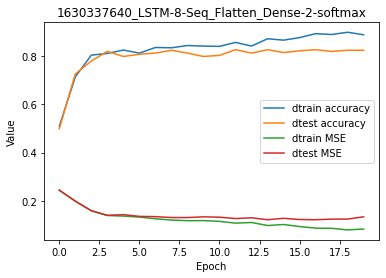

In [20]:
model.plot(path=False)

Overall, we increased accuracy on the testing set but decreased accuracy on the testing set. Adding more complexity in the model did result in overfitting.

### LSTM(sequence=True)-Flatten-(Dense)n with Dropout

Adding one hidden *dense* layer will inevitably result in overfitting. So we set a double dropout with each a probability of 0.5 to pass values forward.

In [21]:
name = 'LSTM-8-Seq_Flatten_Dropout-05_Dense-64-relu_Dropout-05_Dense-2-softmax'

se_hPars['learning_rate'] = 0.1
se_hPars['softmax_temperature'] = 5

layers = [
    embedding,
    LSTM(8, sequences=True),
    Flatten(),
    Dropout(drop_prob=0.5),
    Dense(64, relu),
    Dropout(drop_prob=0.5),
    Dense(2, softmax),
]

model = EpyNN(layers=layers, name=name)

model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

model.train(epochs=20, init_logs=False)

Epoch 19 - Batch 25/25 - Accuracy: 0.875 Cost: 0.09716 - TIME: 14.67s RATE: 4.89e+02e/s TTC: 0s

+-------+----------+----------+----------+-------+----------+-------+-------+-----------------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   |  lrate   |       | accuracy |       |  MSE  |                                    Experiment                                     |
|       |   LSTM   |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                                   |
+-------+----------+----------+----------+-------+----------+-------+-------+-----------------------------------------------------------------------------------+
|   0   | 1.00e-01 | 1.00e-01 | 1.00e-01 | 0.510 |  0.499   | 0.255 | 0.257 | 1630337649_LSTM-8-Seq_Flatten_Dropout-05_Dense-64-relu_Dropout-05_Dense-2-softmax |
|   2   | 1.00e-01 | 1.00e-01 | 1.00e-01 | 0.723 |  0.724   | 0.225 | 0.225 | 1630337649_LSTM

Although we have a pretty harsh dropout setup, we still observe overfitting and the accuracy on the testing set turned to be lower than without the hidden *dense* layer. This to illustrate that even though the largest network is *theoretically* capable of the best regression, this comes with more difficulties in training. 

There is always the question of balancing between the metrics you get and how much they could be improved with respect to the human/computational time it may requires.

## Write, Read & Predict

In [22]:
### Write/read model

model.write()

model = read_model()


### Predict

X_features, _ = prepare_dataset(N_SAMPLES=10)

dset = model.predict(X_features, X_encode=True)

for n, pred, probs in zip(dset.ids, dset.P, dset.A):
    print(n, pred, probs)

Make: /media/synthase/beta/EpyNN/nnlive/ptm_protein/models/1630337649_LSTM-8-Seq_Flatten_Dropout-05_Dense-64-relu_Dropout-05_Dense-2-softmax.pickle
0 0 [0.5444648 0.4555352]
1 1 [0.00743209 0.99256791]
2 0 [0.85033572 0.14966428]
3 0 [0.92507993 0.07492007]
4 0 [0.73692974 0.26307026]
5 0 [0.99880209 0.00119791]
6 0 [0.62423953 0.37576047]
7 1 [2.22108722e-07 9.99999778e-01]
8 0 [0.84764513 0.15235487]
9 0 [0.82549512 0.17450488]
